In [16]:

import random
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

NB_DIR = Path().resolve()
ROOT = NB_DIR.parent
print(ROOT)

# ---- config ----
SEED = 1337

# Portrait Meta glasses frames
IMG_SIZE = (480, 640)   # (W, H)

OUT_STRIDE = 4
OUT_W = IMG_SIZE[0] // OUT_STRIDE
OUT_H = IMG_SIZE[1] // OUT_STRIDE

GAUSS_SIGMA = 2.5       # heatmap sigma at output resolution
BATCH_SIZE = 8
LR = 1e-4
NUM_EPOCHS = 30

# Single directory containing BOTH .png and .json
DATA_DIR = Path(ROOT / "data/gutter_regressor/new")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_all(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all()

print("DEVICE:", DEVICE)
print("DATA_DIR:", DATA_DIR)
print("Input size (W,H):", IMG_SIZE)
print("Output heatmap (W,H):", (OUT_W, OUT_H))


C:\Users\jleto\Projects\rev-vision
DEVICE: cuda
DATA_DIR: C:\Users\jleto\Projects\rev-vision\data\gutter_regressor\new
Input size (W,H): (480, 640)
Output heatmap (W,H): (120, 160)


In [18]:
import json
from pathlib import Path
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

class GutterLineDataset(Dataset):
    def __init__(self, folder):
        self.folder = Path(folder)
        self.images = sorted(self.folder.glob("*.png"))
        assert len(self.images) > 0, "No PNG images found"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        json_path = img_path.with_suffix(".json")
        assert json_path.exists(), f"Missing JSON for {img_path.name}"

        # ---- load image ----
        img_bgr = cv2.imread(str(img_path))
        assert img_bgr is not None
        orig_h, orig_w = img_bgr.shape[:2]

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_rgb = cv2.resize(img_rgb, IMG_SIZE)
        img = img_rgb.astype(np.float32) / 255.0
        img = torch.from_numpy(img).permute(2, 0, 1)  # C,H,W

        # ---- load json ----
        with open(json_path, "r") as f:
            data = json.load(f)

        json_w = data.get("imageWidth", orig_w)
        json_h = data.get("imageHeight", orig_h)

        sx = IMG_SIZE[0] / json_w
        sy = IMG_SIZE[1] / json_h

        # ---- init heatmaps ----
        # channel 0 = left line
        # channel 1 = right line
        heatmaps = np.zeros((2, IMG_SIZE[1], IMG_SIZE[0]), dtype=np.float32)

        for s in data["shapes"]:
            if s["shape_type"] != "line":
                continue

            label = s["label"].lower()
            if label not in ("left", "right"):
                continue

            (x1, y1), (x2, y2) = s["points"]

            # scale to resized image coords
            p1 = (int(x1 * sx), int(y1 * sy))
            p2 = (int(x2 * sx), int(y2 * sy))

            ch = 0 if label == "left" else 1

            # draw thin line
            cv2.line(
                heatmaps[ch],
                p1,
                p2,
                color=1.0,
                thickness=2,
                lineType=cv2.LINE_AA
            )

        # optional: light blur to widen gradient basin
        heatmaps[0] = cv2.GaussianBlur(heatmaps[0], (5, 5), 1.0)
        heatmaps[1] = cv2.GaussianBlur(heatmaps[1], (5, 5), 1.0)

        heatmaps = np.clip(heatmaps, 0.0, 1.0)
        heatmaps = torch.from_numpy(heatmaps)

        return img, heatmaps


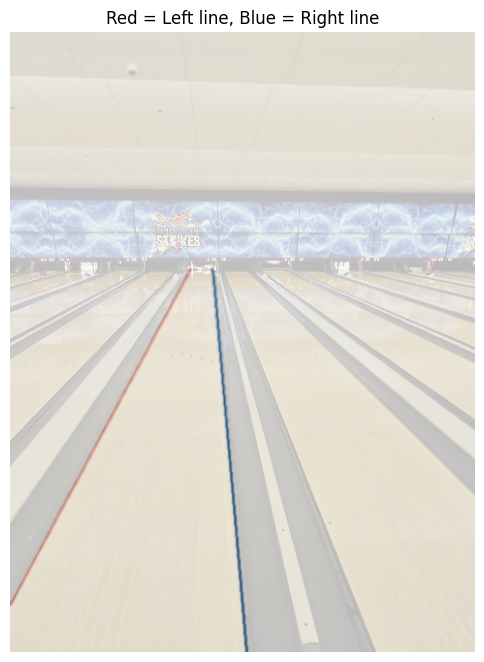

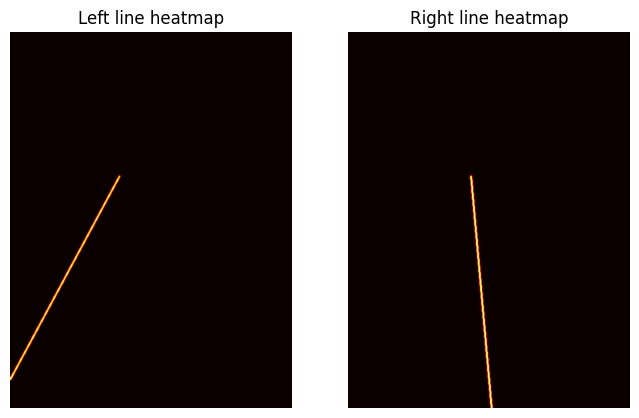

In [21]:
# Sanity check: visualize line heatmaps over image

ds = GutterLineDataset(DATA_DIR)

img, hms = ds[np.random.randint(len(ds))]

img_np = img.permute(1, 2, 0).numpy()

left_hm = hms[0].numpy()
right_hm = hms[1].numpy()

plt.figure(figsize=(6, 10))
plt.imshow(img_np)
plt.imshow(left_hm, alpha=0.5, cmap="Reds")
plt.imshow(right_hm, alpha=0.5, cmap="Blues")
plt.title("Red = Left line, Blue = Right line")
plt.axis("off")
plt.show()

# Individual heatmaps (optional but useful)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(left_hm, cmap="hot")
plt.title("Left line heatmap")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(right_hm, cmap="hot")
plt.title("Right line heatmap")
plt.axis("off")

plt.show()


In [22]:
# Cell — Model definition

class GutterLineNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 2, 1)  # 2 heatmaps: left, right
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x  # logits


In [24]:
# Cell — Training loop

ds = GutterLineDataset(DATA_DIR)
dl = DataLoader(
    ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,   # IMPORTANT on Windows
    pin_memory=True
)

model = GutterLineNet().to(DEVICE)

# base loss
bce = nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

FP_WEIGHT = 5.0  # punish false positives harder

def loss_fn(logits, targets):
    """
    logits: (B,2,H,W)
    targets: (B,2,H,W)
    """
    loss = bce(logits, targets)

    preds = torch.sigmoid(logits)
    false_pos = (targets == 0) & (preds > 0.4)
    loss = torch.where(false_pos, loss * FP_WEIGHT, loss)

    return loss.mean()

model.train()

for epoch in range(NUM_EPOCHS):
    running = 0.0

    for imgs, hms in dl:
        imgs = imgs.to(DEVICE)
        hms = hms.to(DEVICE)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = loss_fn(logits, hms)
        loss.backward()
        optimizer.step()

        running += loss.item()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}  loss={running/len(dl):.4f}")


Epoch 1/30  loss=3.1449
Epoch 2/30  loss=1.2657
Epoch 3/30  loss=0.1771
Epoch 4/30  loss=0.0381
Epoch 5/30  loss=0.0193
Epoch 6/30  loss=0.0161
Epoch 7/30  loss=0.0148
Epoch 8/30  loss=0.0140
Epoch 9/30  loss=0.0135
Epoch 10/30  loss=0.0121
Epoch 11/30  loss=0.0122
Epoch 12/30  loss=0.0114
Epoch 13/30  loss=0.0110
Epoch 14/30  loss=0.0105
Epoch 15/30  loss=0.0095
Epoch 16/30  loss=0.0100
Epoch 17/30  loss=0.0093
Epoch 18/30  loss=0.0088
Epoch 19/30  loss=0.0090
Epoch 20/30  loss=0.0092
Epoch 21/30  loss=0.0087
Epoch 22/30  loss=0.0083
Epoch 23/30  loss=0.0084
Epoch 24/30  loss=0.0083
Epoch 25/30  loss=0.0082
Epoch 26/30  loss=0.0082
Epoch 27/30  loss=0.0078
Epoch 28/30  loss=0.0080
Epoch 29/30  loss=0.0083
Epoch 30/30  loss=0.0076


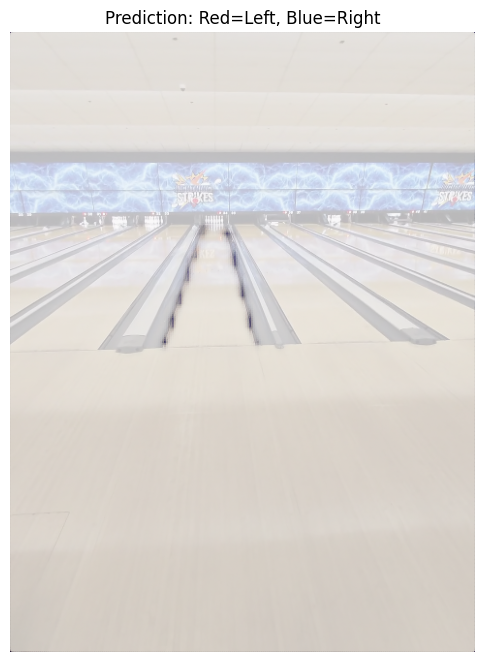

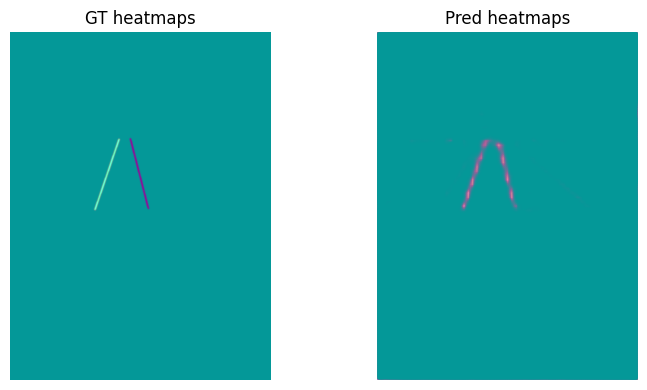

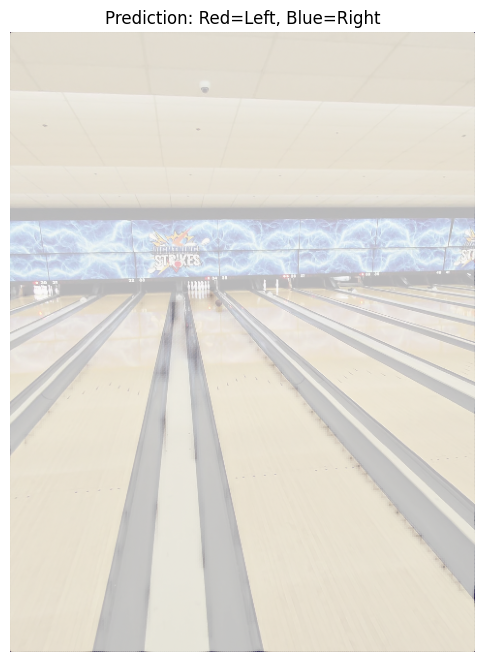

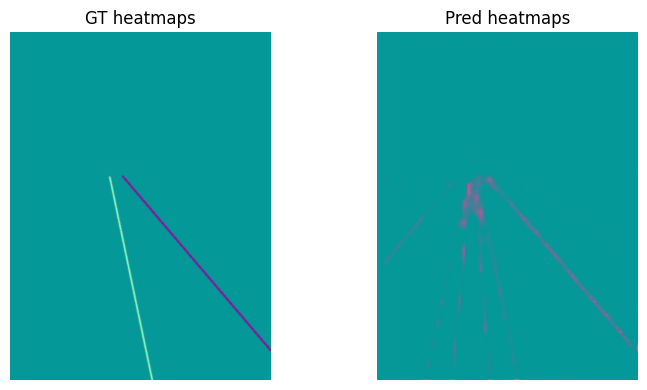

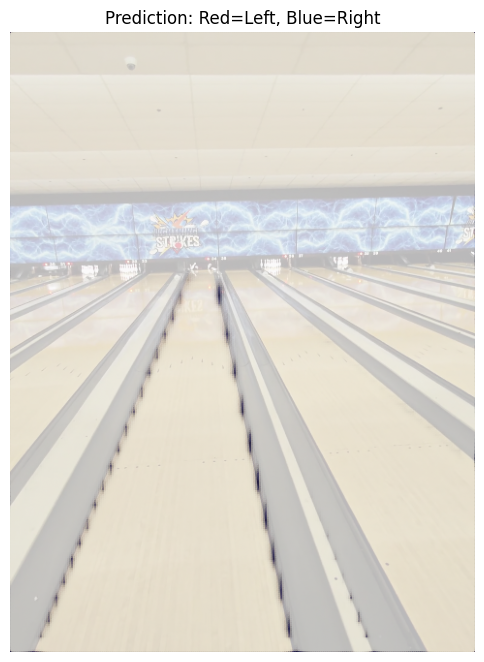

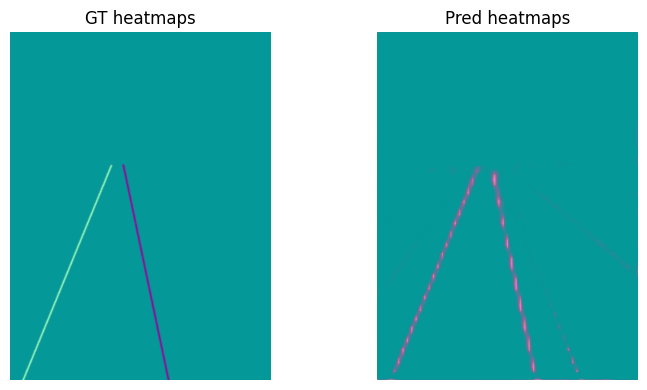

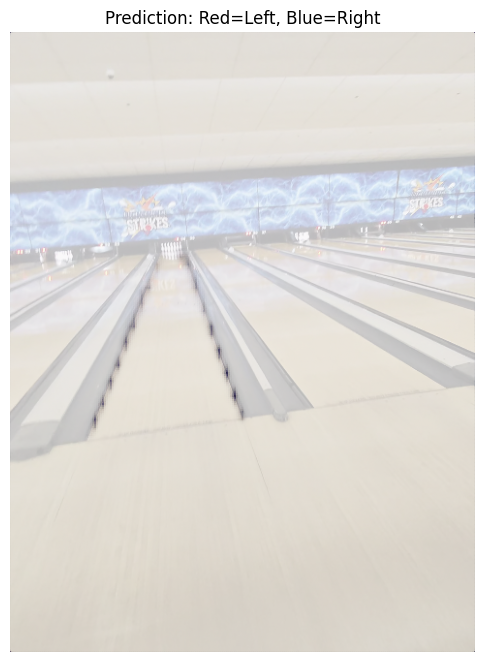

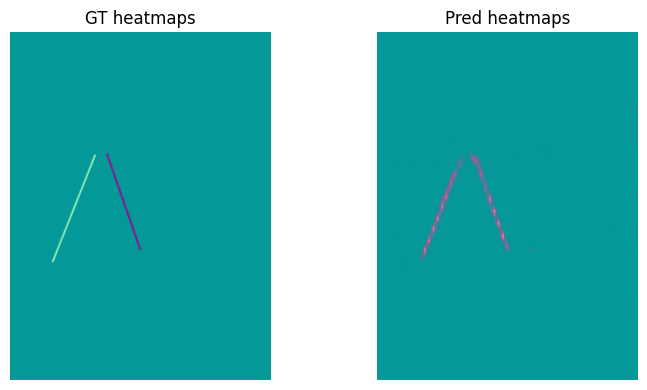

In [30]:
# Cell — Evaluation / inference visualization

model.eval()

idxs = np.random.choice(len(ds), size=min(4, len(ds)), replace=False)

for idx in idxs:
    img, gt_hm = ds[idx]

    with torch.no_grad():
        logits = model(img.unsqueeze(0).to(DEVICE))
        pred = torch.sigmoid(logits)[0].cpu().numpy()

    img_np = img.permute(1, 2, 0).numpy()

    plt.figure(figsize=(6, 10))
    plt.imshow(img_np)
    plt.imshow(pred[0], alpha=0.5, cmap="Reds")
    plt.imshow(pred[1], alpha=0.5, cmap="Blues")
    plt.title("Prediction: Red=Left, Blue=Right")
    plt.axis("off")
    plt.show()

    # Optional side-by-side GT vs Pred
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(gt_hm[0], cmap="hot")
    plt.imshow(gt_hm[1], cmap="cool", alpha=0.6)
    plt.title("GT heatmaps")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred[0], cmap="hot")
    plt.imshow(pred[1], cmap="cool", alpha=0.6)
    plt.title("Pred heatmaps")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


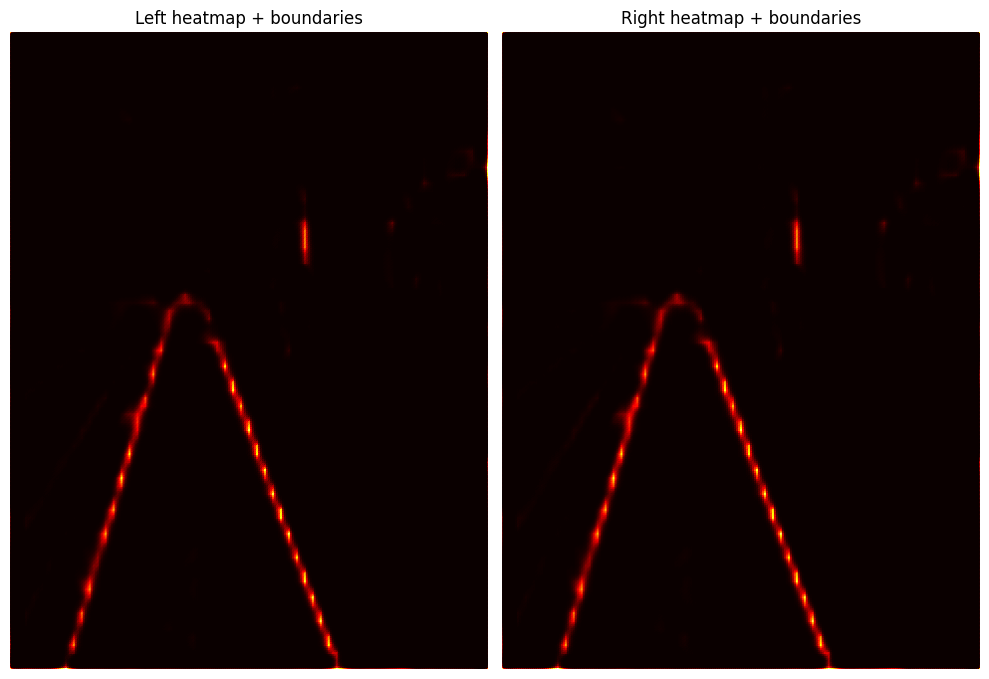

In [ ]:
# ===== Boundary extraction + RGB AND heatmap visualization =====

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

model.eval()

def extract_boundaries(hm, thresh=0.25):
    H, W = hm.shape
    left_pts, right_pts = [], []

    for y in range(H):
        xs = np.where(hm[y] > thresh)[0]
        if len(xs) < 3:
            continue
        left_pts.append((xs.min(), y))
        right_pts.append((xs.max(), y))

    return np.array(left_pts), np.array(right_pts)

def robust_fit(points, keep=90):
    if points.shape[0] < 10:
        return None

    ys = points[:,1]
    xs = points[:,0]

    m, b = np.polyfit(ys, xs, 1)
    resid = np.abs(xs - (m*ys + b))
    cutoff = np.percentile(resid, keep)
    mask = resid < cutoff

    if mask.sum() < 10:
        return None

    return np.polyfit(ys[mask], xs[mask], 1)

def draw_line_on_ax(ax, m, b, H, color):
    ys = np.arange(H)
    xs = m*ys + b
    ax.plot(xs, ys, color=color, linewidth=2)

# ---- inference ----
idx = np.random.randint(len(ds))
img, _ = ds[idx]

with torch.no_grad():
    pred = torch.sigmoid(model(img.unsqueeze(0).to(DEVICE)))[0].cpu().numpy()

img_np = (img.permute(1,2,0).numpy() * 255).astype(np.uint8)

# ---- fit LEFT heatmap boundaries ----
L_left, L_right = extract_boundaries(pred[0], thresh=0.25)
L1 = robust_fit(L_left)
L2 = robust_fit(L_right)

# ---- fit RIGHT heatmap boundaries ----
R_left, R_right = extract_boundaries(pred[1], thresh=0.25)
R1 = robust_fit(R_left)
R2 = robust_fit(R_right)

# ===== FIGURE =====
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# --- RGB + lines ---
ax[0,0].imshow(img_np)
ax[0,0].set_title("RGB + fitted boundary lines")
ax[0,0].axis("off")

H = img_np.shape[0]

for line, color in [(L1,"red"), (L2,"orange"), (R1,"blue"), (R2,"cyan")]:
    if line is not None:
        draw_line_on_ax(ax[0,0], *line, H, color)

# --- Left heatmap + same lines ---
ax[0,1].imshow(pred[0], cmap="hot")
ax[0,1].set_title("Left heatmap + fitted lines")
ax[0,1].axis("off")

for line in [L1, L2]:
    if line is not None:
        draw_line_on_ax(ax[0,1], *line, pred[0].shape[0], "cyan")

# --- Right heatmap + same lines ---
ax[1,1].imshow(pred[1], cmap="hot")
ax[1,1].set_title("Right heatmap + fitted lines")
ax[1,1].axis("off")

for line in [R1, R2]:
    if line is not None:
        draw_line_on_ax(ax[1,1], *line, pred[1].shape[0], "cyan")

# --- empty quadrant (intentional, keeps layout clean) ---
ax[1,0].axis("off")

plt.tight_layout()
plt.show()
